# **Setup and Library Imports**

### **Installing Required Packages**

In [34]:
! pip install --quiet transformers
! pip install --quiet torch
! pip install --quiet datasets
! pip install --quiet scikit-learn
! pip install --quiet matplotlib
! pip install --quiet ipywidgets
! pip install --quiet seaborn

### **Importing Libraries**

In [35]:
import os

# Hugging Face libraries for training and transformer models
from transformers import pipeline

# Evaluation metrics and utilities
from sklearn.metrics import confusion_matrix, classification_report

# Loading datasets for training and evaluation
from datasets import load_dataset

# Data manipulation and display utilities
import pandas as pd
import numpy as np
from tabulate import tabulate
from collections import Counter

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


### **Logging into Hugging Face Hub**

In [36]:
from huggingface_hub import notebook_login

# Execute the login function to access the Hugging Face account
# notebook_login()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### **Defining Model and Dataset Paths**

In [ ]:
models_path = [
    "SodaXII/dinov2-base_rice-disease-02_111824",
    "SodaXII/vit-base-patch16-224_rice-disease-02_111724",
]

dataset_path = "cvmil/rice-disease-02"

# Define the output directory for the test results
output_dir = "./drive/Shareddrives/CS198-Drones/testing_output/"

### **Load Dataset and Extract Labels**

Load the dataset from huggingface and extract the class labels from the training data.

In [39]:
dataset = load_dataset(dataset_path, split="test")
dataset = dataset.train_test_split(test_size=0.5, seed=42)["test"]
labels = dataset.features["label"].names

Generate and display a table showing class distribution of the test set.

In [40]:
data = {
    "Label": labels,
    "Test": Counter(dataset["label"]).values(),
}

print(tabulate(data, headers="keys", tablefmt="psql"))

+-----------------------+--------+
| Label                 |   Test |
|-----------------------+--------|
| bacterial_leaf_blight |    145 |
| brown_spot            |    178 |
| healthy               |    185 |
| leaf_blast            |    110 |
| leaf_scald            |    159 |
| narrow_brown_spot     |    176 |
| neck_blast            |    101 |
| rice_hispa            |    201 |
| sheath_blight         |    196 |
| tungro                |     31 |
+-----------------------+--------+


# **Test Pipieline**

Function to display and save confusion matrix

In [ ]:
def plot_and_save_confusion_matrix(y_true, y_pred, labels, model_name):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    
    # Save the confusion matrix
    os.makedirs(f"{output_dir}/{model_name}", exist_ok=True)
    plt.savefig(f"{output_dir}/{model_name}/confusion_matrix.png")
    plt.show()
    plt.close()

Function to save classification report

In [42]:
def save_classification_report(y_true, y_pred, labels, model_name):
    report = classification_report(y_true, y_pred, target_names=labels)
    print(report)
    
    # Save the report to a text file
    os.makedirs(f"{output_dir}/{model_name}", exist_ok=True)
    with open(f"{output_dir}/{model_name}/classification_report.txt", "w") as f:
        f.write(report)

### **Model Evaluation**

This section evaluates the model on the dataset by running inference on each image and comparing the predicted label with the actual label.

This section computes and displays the confusion matrix and classification report, providing insights into the model's performance on the dataset.

Processing dinov2-base_rice-disease-02_111824: 100%|██████████| 1482/1482 [04:27<00:00,  5.53it/s]


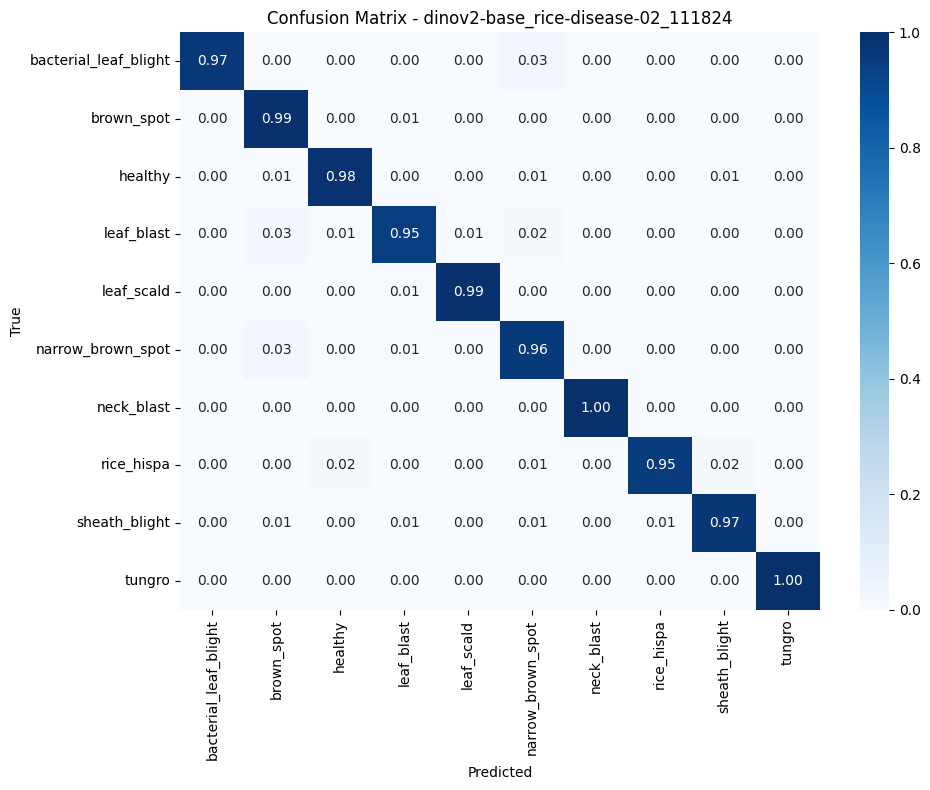

                       precision    recall  f1-score   support

bacterial_leaf_blight       1.00      0.97      0.98        31
           brown_spot       0.93      0.99      0.96       176
              healthy       0.98      0.98      0.98       196
           leaf_blast       0.97      0.95      0.96       185
           leaf_scald       0.99      0.99      0.99       178
    narrow_brown_spot       0.96      0.96      0.96       201
           neck_blast       1.00      1.00      1.00       159
           rice_hispa       0.99      0.95      0.97       110
        sheath_blight       0.98      0.97      0.98       145
               tungro       1.00      1.00      1.00       101

             accuracy                           0.98      1482
            macro avg       0.98      0.98      0.98      1482
         weighted avg       0.98      0.98      0.98      1482



Processing vit-base-patch16-224_rice-disease-02_111724: 100%|██████████| 1482/1482 [03:52<00:00,  6.38it/s]


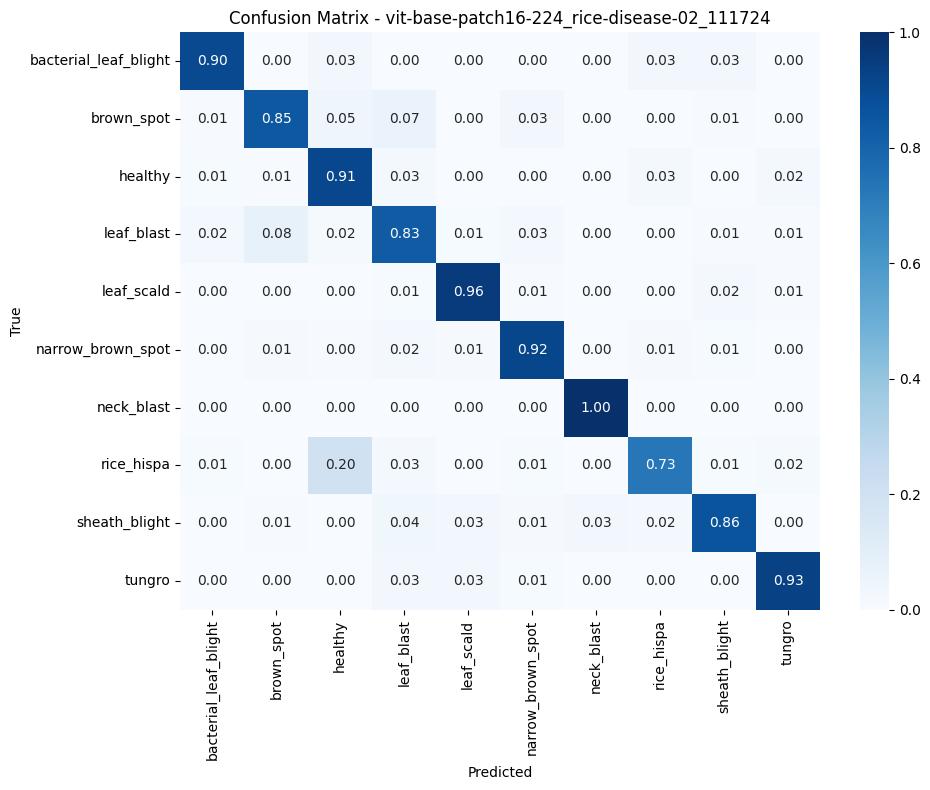

                       precision    recall  f1-score   support

bacterial_leaf_blight       0.78      0.90      0.84        31
           brown_spot       0.88      0.85      0.86       176
              healthy       0.84      0.91      0.87       196
           leaf_blast       0.81      0.83      0.82       185
           leaf_scald       0.93      0.96      0.94       178
    narrow_brown_spot       0.92      0.92      0.92       201
           neck_blast       0.98      1.00      0.99       159
           rice_hispa       0.87      0.73      0.79       110
        sheath_blight       0.93      0.86      0.89       145
               tungro       0.92      0.93      0.93       101

             accuracy                           0.89      1482
            macro avg       0.89      0.89      0.89      1482
         weighted avg       0.89      0.89      0.89      1482

Evaluation completed!


In [43]:
for model_path in models_path:
    model_name = model_path.split("/")[-1]
    classifier = pipeline("image-classification", model=model_path, device='cpu')
    
    predictions = [
        classifier(img["image"])[0] for img in tqdm(dataset, desc=f"Processing {model_name}")
    ]
    y_true = dataset["label"]
    y_pred = [labels.index(pred["label"]) for pred in predictions]
    
    plot_and_save_confusion_matrix(y_true, y_pred, labels, model_name)
    save_classification_report(y_true, y_pred, labels, model_name)

print("Evaluation completed!")